# Model and configuration selection

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
from networks.cnn_v1 import CNNv1
from networks.cnn_v2 import CNNv2
from networks.cnn_v3 import CNNv3

sampling_rate = 100
dataset_path = "ecg_dataset/"
number_of_classes = 5

model = model_config = CNNv3(num_classes=number_of_classes, sampling_rate=sampling_rate)

# Getting data ready for training

In [3]:
from scripts.data_preparation import get_data_ready_for_training

(
    X_train,
    X_val,
    X_test,
    y_train,
    y_val,
    y_test,
    multi_label_binarizer,
) = get_data_ready_for_training(
    dataset_path=dataset_path,
    sampling_rate=model_config.sampling_rate(),
    scale_features=True,
    input_3D=model_config.need_3D_input(),
)

Loaded labels
Loaded ECG signals
Encoded labels
Scaled ECG signals
Reshaped ECG signals to: (1000, 12, 1)
Split training data into training|validation


# Callbacks

In [3]:
from tensorflow._api.v2.v2.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    EarlyStopping(monitor="val_auc", verbose=1, patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_auc", patience=5, verbose=1, min_lr=0.0001),
]

# Model compilation

In [4]:
from tensorflow._api.v2.v2.keras.losses import BinaryCrossentropy
from tensorflow._api.v2.v2.keras.optimizers import Adam
from tensorflow._api.v2.v2.keras.metrics import BinaryAccuracy, Recall, Precision, AUC

model.compile(
    loss=BinaryCrossentropy(),
    optimizer=Adam(),
    metrics=[
        BinaryAccuracy(),
        Recall(),
        Precision(),
        AUC(multi_label=True),
    ],
)

# Model architecture

In [4]:
try:
    model_config.summary()
except ValueError:
    model_config.model_architecture().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000, 12)]        0         
                                                                 
 cnn_block (CNNBlock)        (None, 1000, 32)          1312      
                                                                 
 cnn_block_1 (CNNBlock)      (None, 1000, 64)          6464      
                                                                 
 cnn_block_2 (CNNBlock)      (None, 1000, 128)         25216     
                                                                 
 cnn_block_3 (CNNBlock)      (None, 1000, 64)          24896     
                                                                 
 cnn_block_4 (CNNBlock)      (None, 1000, 32)          6304      
                                                                 
 global_average_pooling1d (G  (None, 32)               0     

# Model training

In [6]:
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=16,
    epochs=100,
    callbacks=callbacks,
    validation_data=(X_val, y_val),
)

Epoch 1/100
7214/7214 [==============================] - 836s 112ms/step - loss: 0.4667 - binary_accuracy: 0.7859 - recall: 0.3493 - precision: 0.6673 - auc: 0.7461 - val_loss: 0.4694 - val_binary_accuracy: 0.8014 - val_recall: 0.4280 - val_precision: 0.6912 - val_auc: 0.8127 - lr: 0.0010
Epoch 2/100
7214/7214 [==============================] - 786s 109ms/step - loss: 0.4055 - binary_accuracy: 0.8208 - recall: 0.5034 - precision: 0.7219 - auc: 0.8209 - val_loss: 0.4551 - val_binary_accuracy: 0.8062 - val_recall: 0.5758 - val_precision: 0.6424 - val_auc: 0.8451 - lr: 0.0010
Epoch 3/100
7214/7214 [==============================] - 793s 110ms/step - loss: 0.3825 - binary_accuracy: 0.8337 - recall: 0.5555 - precision: 0.7391 - auc: 0.8428 - val_loss: 0.4646 - val_binary_accuracy: 0.8266 - val_recall: 0.6506 - val_precision: 0.6725 - val_auc: 0.8592 - lr: 0.0010
Epoch 4/100
7214/7214 [==============================] - 800s 111ms/step - loss: 0.3674 - binary_accuracy: 0.8433 - recall: 0.5885

# Saving model

In [7]:
model.save(filepath=f"saved_models/{model_config.model_name()}", save_format="tf")

INFO:tensorflow:Assets written to: saved_models/cnn_v2_500\assets


INFO:tensorflow:Assets written to: saved_models/cnn_v2_500\assets


# Model loading

In [4]:
from tensorflow import keras

model = keras.models.load_model(f"saved_models/{model_config.model_name()}")

In [5]:
model_config.model_name()

'cnn_v3'

# Model evaluation

In [6]:
y_pred_proba = model.predict(X_test)

68/68 [==============================] - 3s 8ms/step


## Optimal threshold

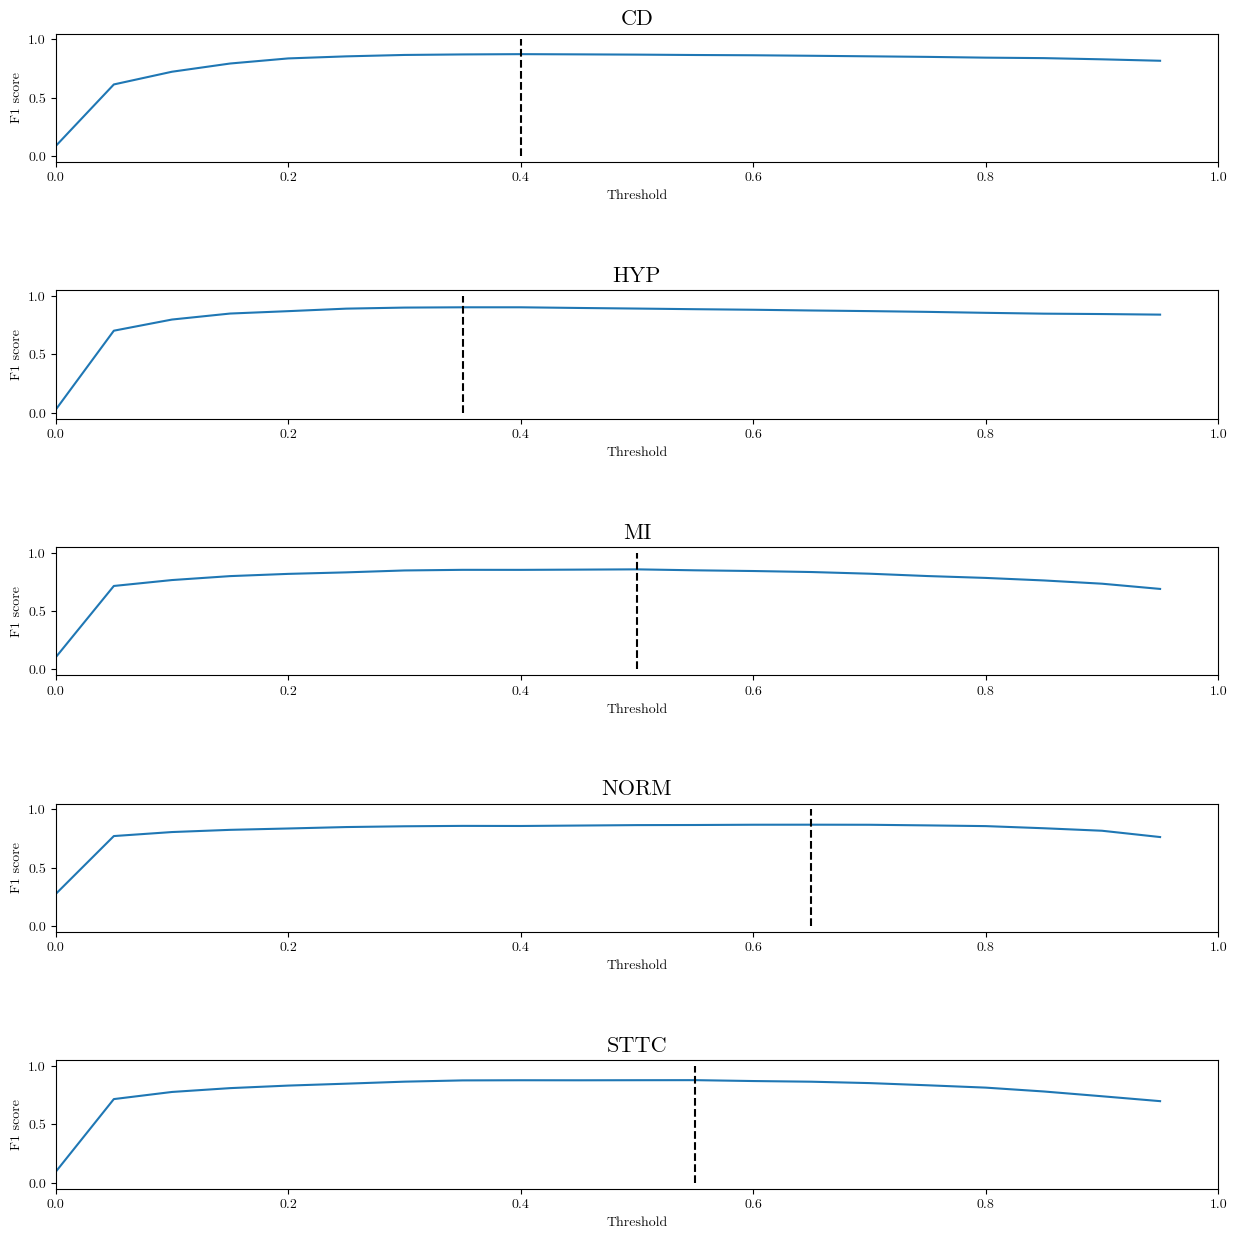

In [7]:
from scripts.data_evaluation import plot_optimal_thresholds

optimal_thresholds = plot_optimal_thresholds(
    y_test, y_pred_proba, directory_name=model_config.model_name(), save_plot=True
)

In [8]:
from scripts.data_evaluation import generate_model_evaluation

generate_model_evaluation(
    y_test=y_test,
    y_pred=(y_pred_proba > 0.5) * 1,
    y_pred_proba=y_pred_proba,
    directory_name=model_config.model_name(),
    file_name="model_evaluation.csv",
    save_data=True,
)

,loss,binary_accuracy,recall,precision,auc
0,0.319,0.879,0.707,0.803,0.784


In [9]:
from scripts.data_evaluation import generate_model_evaluation

generate_model_evaluation(
    y_test=y_test,
    y_pred=(y_pred_proba > optimal_thresholds) * 1,
    y_pred_proba=y_pred_proba,
    directory_name=model_config.model_name(),
    file_name="model_evaluation_optimized.csv",
    save_data=True,
)

,loss,binary_accuracy,recall,precision,auc
0,0.319,0.881,0.71,0.807,0.798


## Confusion matrix

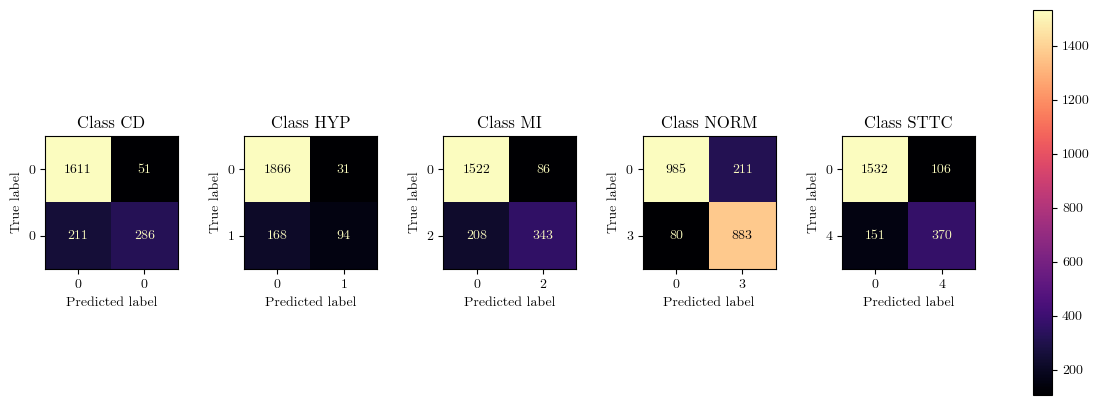

In [10]:
from scripts.data_evaluation import plot_confusion_matrix

plot_confusion_matrix(
    y_test=y_test,
    y_pred=(y_pred_proba > 0.5) * 1,
    class_names=multi_label_binarizer.classes_,
    directory_name=model_config.model_name(),
    file_name="confusion_matrix.png",
    save_plot=True,
)

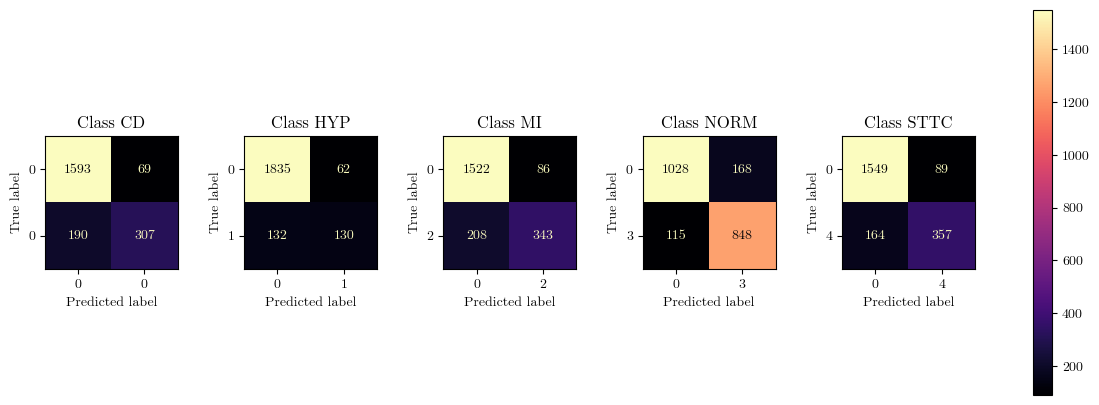

In [11]:
from scripts.data_evaluation import plot_confusion_matrix

plot_confusion_matrix(
    y_test=y_test,
    y_pred=(y_pred_proba > optimal_thresholds) * 1,
    class_names=multi_label_binarizer.classes_,
    directory_name=model_config.model_name(),
    file_name="confusion_matrix_optimized.png",
    save_plot=True,
)

## Classification report

In [12]:
from scripts.data_evaluation import generate_classification_report

generate_classification_report(
    y_test=y_test,
    y_pred=(y_pred_proba > 0.5) * 1,
    class_names=list(multi_label_binarizer.classes_),
    directory_name=model_config.model_name(),
    file_name="classification_report.csv",
    save_data=True,
)

,precision,recall,f1-score,support
CD,0.849,0.575,0.686,497.0
HYP,0.752,0.359,0.486,262.0
MI,0.800,0.623,0.700,551.0
NORM,0.807,0.917,0.859,963.0
STTC,0.777,0.710,0.742,521.0
micro avg,0.803,0.707,0.752,2794.0
macro avg,0.797,0.637,0.694,2794.0
weighted avg,0.802,0.707,0.740,2794.0
samples avg,0.780,0.742,0.747,2794.0


In [13]:
from scripts.data_evaluation import generate_classification_report

generate_classification_report(
    y_test=y_test,
    y_pred=(y_pred_proba > optimal_thresholds) * 1,
    class_names=list(multi_label_binarizer.classes_),
    directory_name=model_config.model_name(),
    file_name="classification_report_optimized.csv",
    save_data=True,
)

,precision,recall,f1-score,support
CD,0.816,0.618,0.703,497.0
HYP,0.677,0.496,0.573,262.0
MI,0.800,0.623,0.700,551.0
NORM,0.835,0.881,0.857,963.0
STTC,0.800,0.685,0.738,521.0
micro avg,0.807,0.710,0.756,2794.0
macro avg,0.786,0.660,0.714,2794.0
weighted avg,0.803,0.710,0.750,2794.0
samples avg,0.767,0.737,0.738,2794.0


# Show predictions on sample patient

In [14]:
from scripts.data_evaluation import generate_sample_patients_predictions

generate_sample_patients_predictions(
    X_test=X_test,
    y_test=y_test,
    model=model,
    threshold=0.5,
    class_names=list(multi_label_binarizer.classes_),
    number_of_patients=15,
    directory_name=model_config.model_name(),
    file_name="sample_patients_predictions.csv",
    save_data=True,
)

1/1 [==============================] - 0s 11ms/step


,CD,HYP,MI,NORM,STTC
Predicted,0,0,0,1,0
True,0,0,0,1,0
---------,-,-,-,-,-
Predicted,0,0,0,1,0
True,0,0,0,1,0
---------,-,-,-,-,-
Predicted,0,0,0,1,0
True,0,0,0,1,0
---------,-,-,-,-,-
Predicted,0,0,0,1,0


In [15]:
from scripts.data_evaluation import generate_sample_patients_predictions

generate_sample_patients_predictions(
    X_test=X_test,
    y_test=y_test,
    model=model,
    threshold=optimal_thresholds,
    class_names=list(multi_label_binarizer.classes_),
    number_of_patients=15,
    directory_name=model_config.model_name(),
    file_name="sample_patients_predictions_optimized.csv",
    save_data=True,
)

1/1 [==============================] - 0s 10ms/step


,CD,HYP,MI,NORM,STTC
Predicted,0,0,0,1,0
True,0,0,0,1,0
---------,-,-,-,-,-
Predicted,0,0,0,1,0
True,0,0,0,1,0
---------,-,-,-,-,-
Predicted,0,0,0,1,0
True,0,0,0,1,0
---------,-,-,-,-,-
Predicted,0,0,0,1,0
